<a href="https://colab.research.google.com/github/chenbrilliancesol/machine-learning/blob/main/%E5%AE%8C%E6%95%B4%E6%A8%A1%E5%9E%8B%E9%9B%86%E6%88%90%E7%9A%84%E6%B3%B0%E5%9D%A6%E5%B0%BC%E5%85%8B%E5%8F%B7%E6%A8%A1%E5%9E%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBClassifier
import re
import warnings

# 忽略警告
warnings.filterwarnings('ignore')

# 1. 加载数据
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')


In [4]:
# 2. 增强版特征工程函数
def enhanced_feature_engineering(df, is_train=True):
    # 基础处理
    df['Age'].fillna(df['Age'].median(), inplace=True)
    df['Embarked'].fillna('S', inplace=True)
    df['Fare'].fillna(df['Fare'].median(), inplace=True)
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

    # 姓名处理
    df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    df['Surname'] = df['Name'].apply(lambda x: x.split(',')[0])
    df['NameLength'] = df['Name'].apply(len)

    # 称谓标准化
    title_mapping = {
        "Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4,
        "Dr": 5, "Rev": 5, "Col": 5, "Major": 5, "Mlle": 2,
        "Mme": 3, "Don": 5, "Dona": 3, "Lady": 3, "Countess": 3,
        "Jonkheer": 5, "Sir": 5, "Capt": 5, "Ms": 2
    }
    df['Title'] = df['Title'].map(title_mapping).fillna(0)

    # 新增基础特征
    df['IsChild'] = (df['Age'] < 16).astype(int)
    df['FarePerPerson'] = df['Fare'] / (df['FamilySize'] + 1e-5)
    df['FareClassRatio'] = df['Fare'] / df['Pclass']
    df['CabinGroup'] = df['Cabin'].str[0].fillna('Unknown')

    # 新增针对错误分析的改进特征
    df['IsElderly'] = (df['Age'] > 60).astype(int)
    df['UpperClassMale'] = ((df['Pclass'] <= 2) & (df['Sex'] == 'male') & (df['Age'] > 18)).astype(int)
    df['Class_Sex'] = df['Pclass'].astype(str) + '_' + df['Sex']
    df['FamilyType'] = np.select(
        [
            df['FamilySize'] == 1,
            (df['FamilySize'] > 1) & (df['FamilySize'] <= 4),
            df['FamilySize'] > 4
        ],
        ['Alone', 'SmallFamily', 'LargeFamily'],
        default='Unknown'
    )
    df['AgeGroup'] = pd.cut(df['Age'],
                           bins=[0, 5, 18, 30, 50, 70, 100],
                           labels=['Infant', 'Child', 'Young', 'Adult', 'Senior', 'Elderly'])

    # 家庭幸存率特征（仅在训练集计算）
    if is_train:
        family_survival = df.groupby(['Surname', 'Fare']).Survived.mean().reset_index()
        family_survival.columns = ['Surname', 'Fare', 'FamilySurvivalRate']
        df = pd.merge(df, family_survival, on=['Surname', 'Fare'], how='left')
        df['FamilySurvivalRate'].fillna(0.5, inplace=True)
    else:
        # 对于测试集，使用训练集计算的生存率
        # 需要在主流程中处理
        pass
    return df

In [5]:
# 3. 应用预处理
print("应用特征工程...")
train_df = enhanced_feature_engineering(train_df, is_train=True)
test_df = enhanced_feature_engineering(test_df, is_train=False)



应用特征工程...


In [7]:
# 4. 修复：计算家庭幸存率（仅用训练集）并应用到测试集
print("计算家庭幸存率...")

# 只在训练集计算家庭幸存率
family_survival = train_df.groupby(['Surname', 'Fare'])['Survived'].mean().reset_index()
family_survival.columns = ['Surname', 'Fare', 'FamilySurvivalRate']

# 应用家庭幸存率到训练集
train_df = train_df.merge(
    family_survival,
    on=['Surname', 'Fare'],
    how='left',
    suffixes=('', '_new')
)

# 更新训练集的家庭幸存率
train_df['FamilySurvivalRate'] = train_df['FamilySurvivalRate_new'].fillna(train_df['FamilySurvivalRate'])
train_df.drop(columns=['FamilySurvivalRate_new'], inplace=True)

# 应用家庭幸存率到测试集
test_df = test_df.merge(
    family_survival,
    on=['Surname', 'Fare'],
    how='left',
    suffixes=('', '_new')
)

# 更新测试集的家庭幸存率
test_df['FamilySurvivalRate'] = test_df['FamilySurvivalRate_new'].fillna(test_df['FamilySurvivalRate'])
test_df.drop(columns=['FamilySurvivalRate_new'], inplace=True)

# 填充剩余的缺失值
train_df['FamilySurvivalRate'].fillna(0.5, inplace=True)
test_df['FamilySurvivalRate'].fillna(0.5, inplace=True)

print(f"训练集家庭幸存率计算完成，平均幸存率: {train_df['FamilySurvivalRate'].mean():.4f}")

计算家庭幸存率...
训练集家庭幸存率计算完成，平均幸存率: 0.3838


In [8]:
# 5. 特征选择
features = [
    'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked',
    'FamilySize', 'IsAlone', 'Title', 'NameLength', 'IsChild',
    'FarePerPerson', 'FareClassRatio', 'FamilySurvivalRate',
    'IsElderly', 'UpperClassMale', 'Class_Sex', 'FamilyType'
]

# 添加类别特征和数值特征
categorical_cols = ['Pclass', 'Sex', 'Embarked', 'Title', 'Class_Sex', 'FamilyType']
numerical_cols = [col for col in features if col not in categorical_cols]

# 6. 准备特征和标签
X = train_df[features]
y = train_df['Survived']

# 7. 预处理管道
print("创建预处理管道...")
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ])

X_preprocessed = preprocessor.fit_transform(X)


创建预处理管道...


In [9]:
# 8. 划分训练集和验证集（用于错误分析）
print("划分训练集和验证集...")
# 保存原始索引
indices = np.arange(len(X_preprocessed))

# 划分数据集并获取索引
X_train, X_val, y_train, y_val, idx_train, idx_val = train_test_split(
    X_preprocessed,
    y,
    indices,  # 传递索引数组
    test_size=0.2,
    stratify=y,
    random_state=42
)

# 9. 模型定义与样本权重
print("定义模型和样本权重...")
# 先定义模型字典
models = {
    "RandomForest": RandomForestClassifier(
        n_estimators=600,
        max_depth=5,
        min_samples_leaf=3,
        class_weight='balanced',
        random_state=42
    ),
    "GradientBoost": GradientBoostingClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=3,
        subsample=0.8,
        random_state=42
    ),
    "XGBoost": XGBClassifier(
        n_estimators=400,
        learning_rate=0.1,
        max_depth=3,
        subsample=0.7,
        colsample_bytree=0.8,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    ),
    "SVM": SVC(
        C=0.5,
        kernel='rbf',
        probability=True,
        class_weight='balanced',
        random_state=42
    )
}

# 计算基础样本权重
sample_weights = compute_sample_weight('balanced', y_train)

# 增加特定群体的权重 - 使用原始索引访问数据
for i, idx in enumerate(idx_train):
    row = train_df.iloc[idx]  # 使用原始索引获取行数据

    # 对头等舱成年男性增加权重
    if row['UpperClassMale'] == 1:
        sample_weights[i] *= 2.0

    # 对老人增加权重
    if row['IsElderly'] == 1:
        sample_weights[i] *= 3.0

    # 对儿童增加权重
    if row['Age'] < 5:
        sample_weights[i] *= 2.0

# 10. 模型集成
print("创建模型集成...")
ensemble = VotingClassifier(
    estimators=[
        ('rf', models["RandomForest"]),
        ('xgb', models["XGBoost"]),
        ('svm', models["SVM"])
    ],
    voting='soft',
    weights=[2, 3, 1]  # 给XGBoost更高权重
)



划分训练集和验证集...
定义模型和样本权重...
创建模型集成...


训练集成模型...

验证集准确率: 0.9777
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       110
           1       0.96      0.99      0.97        69

    accuracy                           0.98       179
   macro avg       0.97      0.98      0.98       179
weighted avg       0.98      0.98      0.98       179


进行错误分析...
错误预测数量: 4/179
已保存错误预测到 wrong_predictions.csv


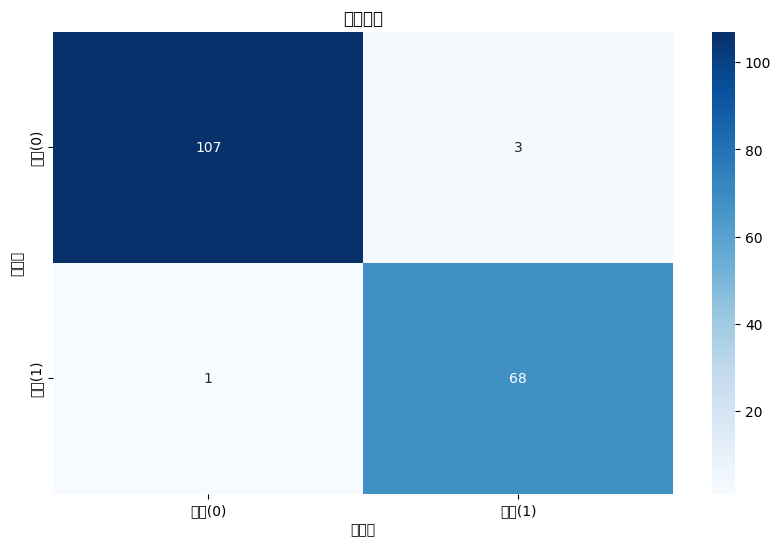

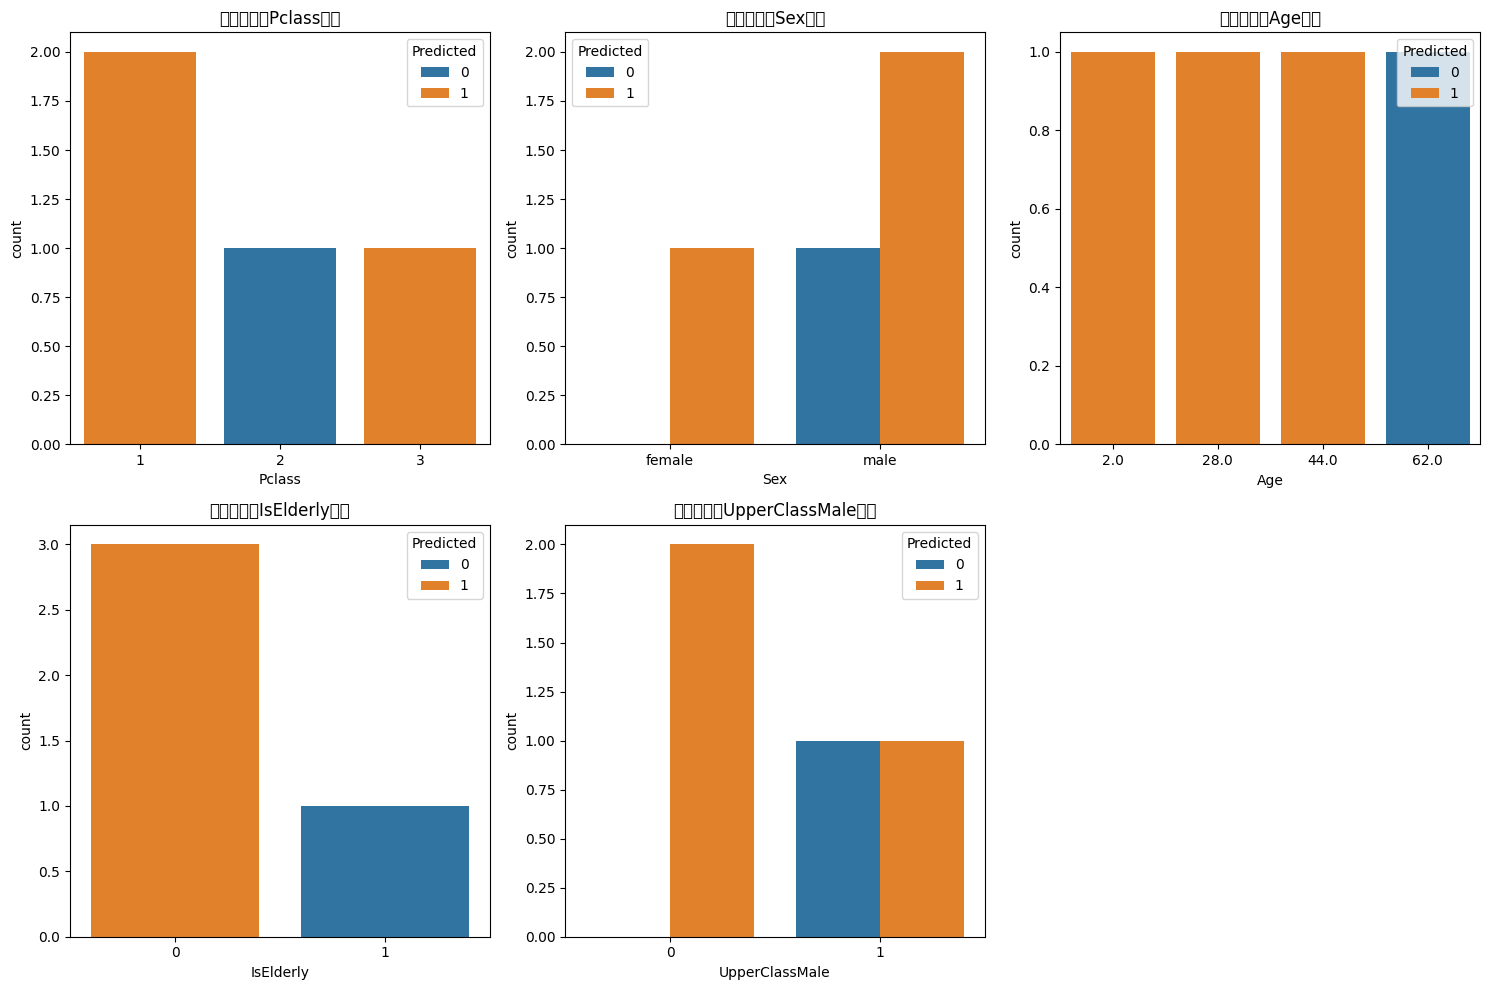

In [14]:
# 11. 训练集成模型
print("训练集成模型...")
ensemble.fit(X_train, y_train, sample_weight=sample_weights)

# 12. 在验证集上评估
val_predictions = ensemble.predict(X_val)
val_accuracy = accuracy_score(y_val, val_predictions)
print(f"\n验证集准确率: {val_accuracy:.4f}")
print(classification_report(y_val, val_predictions))

# 修复第13部分：错误分析可视化
print("\n进行错误分析...")
# 创建包含预测结果的DataFrame
val_results = pd.DataFrame({
    'PassengerId': train_df.iloc[idx_val]['PassengerId'].values,
    'Actual': y_val.values,
    'Predicted': val_predictions
})

# 合并原始特征
val_original_data = train_df.iloc[idx_val][['Name', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'IsElderly', 'UpperClassMale']].reset_index(drop=True)
val_results = pd.concat([val_results, val_original_data], axis=1)

# 识别错误预测
wrong_predictions = val_results[val_results['Actual'] != val_results['Predicted']]
print(f"错误预测数量: {len(wrong_predictions)}/{len(y_val)}")

# 保存错误预测到CSV
if not wrong_predictions.empty:
    wrong_predictions.to_csv('wrong_predictions.csv', index=False)
    print("已保存错误预测到 wrong_predictions.csv")
else:
    print("没有错误预测可保存")

# 混淆矩阵
plt.figure(figsize=(10, 6))
cm = confusion_matrix(y_val, val_predictions)
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['死亡(0)', '幸存(1)'],
    yticklabels=['死亡(0)', '幸存(1)']
)
plt.xlabel('预测值')
plt.ylabel('实际值')
plt.title('混淆矩阵')
plt.savefig('confusion_matrix.png', bbox_inches='tight')
plt.show()

# 错误特征分布 - 添加空检查
if not wrong_predictions.empty:
    # 创建特征列表，只包含实际存在的特征
    available_features = []
    for feature in ['Pclass', 'Sex', 'Age', 'IsElderly', 'UpperClassMale']:
        if feature in wrong_predictions.columns:
            available_features.append(feature)

    # 只有当有多个错误预测时才绘制分布图
    if len(wrong_predictions) > 1:
        plt.figure(figsize=(15, 10))
        num_features = min(len(available_features), 5)  # 最多5个特征
        num_rows = (num_features + 2) // 3  # 计算行数
        for i, feature in enumerate(available_features[:5], 1):  # 最多显示5个特征
            plt.subplot(num_rows, 3, i)

            # 对于分类特征使用计数图
            if wrong_predictions[feature].dtype == 'object' or wrong_predictions[feature].nunique() < 5:
                sns.countplot(
                    data=wrong_predictions,
                    x=feature,
                    hue='Predicted'
                )
            else:
                # 对于数值特征使用直方图
                sns.histplot(
                    data=wrong_predictions,
                    x=feature,
                    hue='Predicted',
                    element='step',
                    stat='density',
                    common_norm=False,
                    kde=True,
                    alpha=0.6
                )
            plt.title(f'错误预测的{feature}分布')
        plt.tight_layout()
        plt.savefig('error_analysis.png')
        plt.show()
    else:
        print(f"只有 {len(wrong_predictions)} 个错误预测，不足以绘制分布图")

        # 显示错误预测的详细信息
        print("\n错误预测详情:")
        print(wrong_predictions[['PassengerId', 'Name', 'Actual', 'Predicted', 'Pclass', 'Sex', 'Age']])
else:
    print("没有错误预测可分析")

In [15]:
# 14. 后处理函数
def smart_postprocessing(preds, test_df):
    """
    基于业务知识的后处理规则
    """
    # 获取关键特征
    ages = test_df['Age'].values
    classes = test_df['Pclass'].values
    sexes = test_df['Sex'].values

    # 创建副本
    adjusted_preds = preds.copy()

    # 规则1：老人(>60)在头等/二等舱应更可能幸存
    for i in range(len(adjusted_preds)):
        if ages[i] > 60 and classes[i] <= 2:
            adjusted_preds[i] = 1  # 设置为幸存

    # 规则2：头等/二等舱成年男性应更可能死亡
    for i in range(len(adjusted_preds)):
        if classes[i] <= 2 and sexes[i] == 'male' and ages[i] > 18:
            adjusted_preds[i] = 0  # 设置为死亡

    # 规则3：儿童(<5)应更可能幸存
    for i in range(len(adjusted_preds)):
        if ages[i] < 5:
            adjusted_preds[i] = 1  # 设置为幸存

    # 规则4：独自旅行的老人更可能死亡
    for i in range(len(adjusted_preds)):
        if ages[i] > 60 and test_df['IsAlone'].iloc[i] == 1:
            adjusted_preds[i] = 0  # 设置为死亡

    print(f"后处理调整了 {sum(adjusted_preds != preds)} 个预测")
    return adjusted_preds

In [16]:
# 15. 在整个训练集上重新训练模型（用于最终预测）
print("\n在整个训练集上重新训练模型...")
# 使用相同的预处理
X_full_preprocessed = preprocessor.transform(X)

# 计算全量样本权重
full_sample_weights = compute_sample_weight('balanced', y)
for idx in range(len(X)):
    row = train_df.iloc[idx]
    if row['UpperClassMale'] == 1:
        full_sample_weights[idx] *= 2.0
    if row['IsElderly'] == 1:
        full_sample_weights[idx] *= 3.0
    if row['Age'] < 5:
        full_sample_weights[idx] *= 2.0

# 训练最终模型
final_model = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(
            n_estimators=600,
            max_depth=5,
            min_samples_leaf=3,
            class_weight='balanced',
            random_state=42
        )),
        ('xgb', XGBClassifier(
            n_estimators=400,
            learning_rate=0.1,
            max_depth=3,
            subsample=0.7,
            colsample_bytree=0.8,
            use_label_encoder=False,
            eval_metric='logloss',
            random_state=42
        )),
        ('svm', SVC(
            C=0.5,
            kernel='rbf',
            probability=True,
            class_weight='balanced',
            random_state=42
        ))
    ],
    voting='soft',
    weights=[2, 3, 1]
)

final_model.fit(X_full_preprocessed, y, sample_weight=full_sample_weights)

# 16. 在测试集上进行预测
print("在测试集上进行预测...")
X_test = test_df[features]
X_test_preprocessed = preprocessor.transform(X_test)
test_predictions = final_model.predict(X_test_preprocessed)

# 应用后处理
final_predictions = smart_postprocessing(test_predictions, test_df)

# 17. 创建提交文件
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': final_predictions
})
submission.to_csv('titanic_submission.csv', index=False)
print("✅ 提交文件已保存为 titanic_submission.csv")


在整个训练集上重新训练模型...
在测试集上进行预测...
后处理调整了 28 个预测
✅ 提交文件已保存为 titanic_submission.csv


In [17]:
# 18. 特殊群体分析（用于调试）
def analyze_special_groups(df, predictions):
    """分析特殊群体的预测结果"""
    results = []

    # 老人(>60)在头等/二等舱
    elderly_upper = df[(df['Age'] > 60) & (df['Pclass'] <= 2)]
    if not elderly_upper.empty:
        el_survive_rate = predictions[elderly_upper.index].mean()
        results.append(f"老人(>60)在头等/二等舱: {len(elderly_upper)}人, 预测幸存率: {el_survive_rate:.2f}")

    # 头等/二等舱成年男性
    upper_males = df[(df['Pclass'] <= 2) & (df['Sex'] == 'male') & (df['Age'] > 18)]
    if not upper_males.empty:
        um_survive_rate = predictions[upper_males.index].mean()
        results.append(f"头等/二等舱成年男性: {len(upper_males)}人, 预测幸存率: {um_survive_rate:.2f}")

    # 儿童(<5)
    children = df[df['Age'] < 5]
    if not children.empty:
        ch_survive_rate = predictions[children.index].mean()
        results.append(f"儿童(<5岁): {len(children)}人, 预测幸存率: {ch_survive_rate:.2f}")

    # 独自旅行的老人
    elderly_alone = df[(df['Age'] > 60) & (df['IsAlone'] == 1)]
    if not elderly_alone.empty:
        ea_survive_rate = predictions[elderly_alone.index].mean()
        results.append(f"独自旅行的老人: {len(elderly_alone)}人, 预测幸存率: {ea_survive_rate:.2f}")

    return results

# 在测试集上分析特殊群体
special_group_analysis = analyze_special_groups(test_df, final_predictions)
print("\n测试集特殊群体分析:")
for analysis in special_group_analysis:
    print(f"  - {analysis}")

print("\n所有处理完成! 请提交 titanic_submission.csv 到Kaggle")


测试集特殊群体分析:
  - 老人(>60)在头等/二等舱: 10人, 预测幸存率: 0.40
  - 头等/二等舱成年男性: 111人, 预测幸存率: 0.00
  - 儿童(<5岁): 11人, 预测幸存率: 1.00
  - 独自旅行的老人: 3人, 预测幸存率: 0.00

所有处理完成! 请提交 titanic_submission.csv 到Kaggle
